In [213]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD, NMF, PCA, SparsePCA
from sklearn.preprocessing import StandardScaler

import math
import re
import imblearn

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict

%matplotlib inline
import matplotlib.pyplot as plt

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [262]:
features_df = pd.read_csv(
    "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    "training_set_labels.csv", 
    index_col="respondent_id"
)
print(len(labels_df))
features_df.head()

26707


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### Oversampling Data:

In [253]:
#Oversampling strategy: https://stackoverflow.com/questions/63430246/how-to-over-under-sample-data-with-multiple-target-variablemulti-output
df = features_df
df['h1n1_vaccine'] = labels_df['h1n1_vaccine']
df['seasonal_vaccine'] = labels_df['seasonal_vaccine']

#df['string_health_insurance'] = df['health_insurance'].astype(str) #Convert health insurance to string

#class_counts = df['race'].value_counts() #Oversample race
#class_counts = df['sex'].value_counts() #Oversample gender
class_counts = df['age_group'].value_counts() #Oversample age
#class_counts = df['string_health_insurance'].value_counts() #Oversample health_insurance
#class_counts = df['marital_status'].value_counts() #Oversample marital status
#class_counts = df['income_poverty'].value_counts() #Oversample income poverty

class_weights = len(class_counts)/class_counts
df = df.sample(
    n=class_counts.max()*len(class_counts),
    #weights=df['race'].map(class_weights), #Oversample race
    #weights=df['sex'].map(class_weights), #Oversample gender
    weights=df['age_group'].map(class_weights), #Oversample age
    #weights=df['string_health_insurance'].map(class_weights), #Oversample health insurance
    #weights=df['marital_status'].map(class_weights), #Oversample marital status
    #weights=df['income_poverty'].map(class_weights), #Oversample income poverty
    replace=True)

frames = [df['h1n1_vaccine'], df['seasonal_vaccine']]
labels_df = pd.concat(frames, axis=1)
print(len(labels_df))
#features_df = df.drop(['string_health_insurance'], axis=1) #For health insurance
features_df = df.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)

print(len(features_df))

34215
34215


In [263]:
# One-hot encoding
categorical_columns = features_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# One-hot encoding of string/categorical features
cont_features = features_df[numerical_columns]#.drop(['challengeID'], axis=1)
# To remove nan values, replace with mean
for column in cont_features.columns.tolist():
    cont_features[column] = cont_features[column].fillna(cont_features[column].mean())
cat_features = features_df[categorical_columns]
print("One-hot encoding of categorical features...")
cat_features = pd.get_dummies(cat_features.astype(str), dummy_na=True)
# All features: combining continuous features with encoded categorical features
all_features_df = pd.concat([cont_features, cat_features], axis=1)
# To get rid of any [, ], or < in column names, which throws a weird error for xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
all_features_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in all_features_df.columns.values]
features_df_original = features_df
features_df = all_features_df
features_df.head(5)

One-hot encoding of categorical features...


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000000,...,0,0,0,0,0,1,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.220312,...,0,0,0,0,0,0,0,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Dimension Reduction of Data via PCA

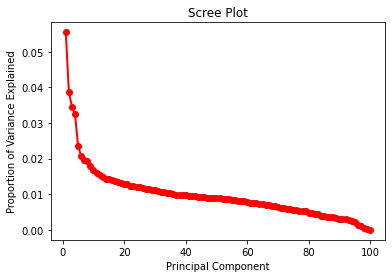

In [214]:
train_df = features_df
#Try out multiple and find the lowest reconstruction error, use that
x = StandardScaler().fit_transform(train_df)
# PCA on regular train_df, not sparse matrix
pca = PCA()
pca_fit = pca.fit(x)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values[0:100], pca.explained_variance_ratio_[0:100], 'ro-', linewidth=2)
#plt.plot(PC_values[1:10], np.cumsum(pca.explained_variance_ratio_)[1:10], 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [264]:
#Note from above can deduce that proportion of var. explained begins to plateau around 20 PCs, therefore this is optimal
optimal_n=20
pca = PCA(n_components=optimal_n, random_state=41)
lower_dim = pca.fit_transform(x)
features_df = lower_dim

In [30]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

### Selection of Classifier

In [259]:
#numeric_cols = features_df.columns[features_df.dtypes != "object"].values

numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)
#Uncomment for 2 Log reg or Random forest and pick 1 estimator
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1) #Uncomment to use Log reg
     #estimator=RandomForestClassifier(random_state=0) #100 trees default, Uncomment to use Random Tree 
)

#Uncomment for Lasso
# estimators = MultiOutputRegressor(
#     estimator = linear_model.Lasso(alpha=0.5) #Can change Alpha and weight of regularization term
# )

full_pipeline = Pipeline([
    #("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [265]:
#Training/testing on all data
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [266]:
# Train model on all data
full_pipeline.fit(X_train, y_train)
#preds = full_pipeline.predict_proba(X_eval)
preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')

y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index)

y_preds_outcome = pd.DataFrame(
{
    "h1n1_vaccine": preds_outcome[:, 0],
    "seasonal_vaccine": preds_outcome[:, 1],
},
index = y_eval.index)

# #Overall MSE and ROC
# print(mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
# print(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))

print("Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
print("Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
print("Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))

print("Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
print("Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
print("Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))


Accuracy 0.8221012026321761
Precision 0.6563786008230452
Recall 0.3408119658119658
Accuracy 0.7378034944406626
Precision 0.7278271918678526
Recall 0.6978557504873294


In [229]:
#Get data on each race:
black = features_df_original.loc[features_df_original['race'] == "Black"]
black_labels = labels_df.iloc[[i for i in list(black.index)]]
black = features_df.iloc[[i for i in list(black.index)]]
#black = features_df[list(black.index)] #For PCA-reduced form
print(len(black_labels))

white = features_df_original.loc[features_df_original['race'] == "White"]
white_labels = labels_df.iloc[[i for i in list(white.index)]]
white = features_df.iloc[[i for i in list(white.index)]]
#white = features_df[list(white.index)] #For PCA-reduced form
print(len(white_labels))

hispanic = features_df_original.loc[features_df_original['race'] == "Hispanic"]
hispanic_labels = labels_df.iloc[[i for i in list(hispanic.index)]]
hispanic = features_df.iloc[[i for i in list(hispanic.index)]]
#hispanic = features_df[list(hispanic.index)] #For PCA-reduced form
print(len(hispanic_labels))

other = features_df_original.loc[features_df_original['race'] == "Other or Multiple"]
other_labels = labels_df.iloc[[i for i in list(other.index)]]
other = features_df.iloc[[i for i in list(other.index)]]
#other = features_df[list(other.index)] #For PCA-reduced form
print(len(other_labels))

2118
21222
1755
1612


White Accuracy 0.8352370074243289
White Precision 0.6830917874396135
White Recall 0.4611872146118721
White Accuracy 0.779554540262707
White Precision 0.7789225787459523
White Recall 0.7694097121256179
Black Accuracy 0.8426323319027181
Black Precision 0.42857142857142855
Black Recall 0.17307692307692307
Black Accuracy 0.7510729613733905
Black Precision 0.6714975845410628
Black Recall 0.5673469387755102
Hispanic Accuracy 0.7931034482758621
Hispanic Precision 0.5079365079365079
Hispanic Recall 0.2644628099173554
Hispanic Accuracy 0.6931034482758621
Hispanic Precision 0.5536723163841808
Hispanic Recall 0.49746192893401014
Other or Multiple Accuracy 0.7763157894736842
Other or Multiple Precision 0.4772727272727273
Other or Multiple Recall 0.3652173913043478
Other or Multiple Accuracy 0.706766917293233
Other or Multiple Precision 0.6602870813397129
Other or Multiple Recall 0.6188340807174888


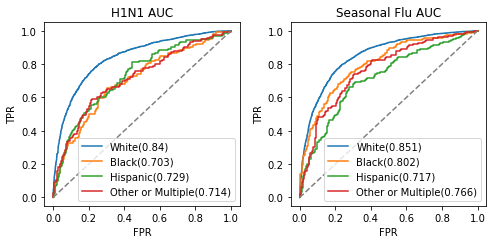

In [230]:
#Train and test per each race
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
races = [white, black, hispanic, other]
races_labels = [white_labels, black_labels, hispanic_labels, other_labels]
names = ["White", "Black", "Hispanic", "Other or Multiple"]
legend_h1n1 = []
legend_seasonal = []
for race in range(len(races)):
    X_train, X_eval, y_train, y_eval = train_test_split(
    races[race],
    races_labels[race],
    test_size=0.33,
    shuffle=True,
    stratify=races_labels[race],
    random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    #preds = preds_outcome #For Lasso

#y_preds for Random forest and Log reg (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
   index = y_eval.index)
    y_preds_outcome = pd.DataFrame(
    {
        "h1n1_vaccine": preds_outcome[:, 0],
        "seasonal_vaccine": preds_outcome[:, 1],
    },
   index = y_eval.index)

#y_preds for Lasso (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[:, 0],
#         "seasonal_vaccine": preds[:,1],
#     },
#     index = y_eval.index)
    #Overall MSE and ROC
    
    #For Log/Random Forest
    print(names[race], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[race],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[race],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
    print(names[race],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[race],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[race],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    
#     #For Lasso
#     print(names[race], "R2 Score", full_pipeline.score(X_eval, y_eval))
#     print(names[race], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
#     print(names[race], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #print(names[race], roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))

    #print(names[race], roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #Plotting combined AUC (For Log/Random Forest)
    fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
    ax[0].plot(fpr, tpr)

    fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
    ax[1].plot(fpr, tpr)
    legend_h1n1.append(names[race]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
    legend_seasonal.append(names[race]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")

#For Log/Random Forest    
ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[0].set_title(
    "H1N1 AUC"
)
ax[0].legend(legend_h1n1)

ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[1].set_ylabel('TPR')
ax[1].set_xlabel('FPR')
ax[1].set_title(
    "Seasonal Flu AUC")

ax[1].legend(legend_seasonal)

fig.tight_layout()   

In [231]:
#Data for each gender:
female = features_df_original.loc[features_df_original['sex'] == "Female"]
female_labels = labels_df.iloc[[i for i in list(female.index)]]
female = features_df.iloc[[i for i in list(female.index)]]
#female = features_df[list(female.index)] #For PCA
print(len(female_labels))

male = features_df_original.loc[features_df_original['sex'] == "Male"]
male_labels = labels_df.iloc[[i for i in list(male.index)]]
male = features_df.iloc[[i for i in list(male.index)]]
#male = features_df[list(male.index)] #For PCA
print(len(male_labels))

15858
10849


Female Accuracy 0.8324417271685136
Female Precision 0.6798941798941799
Female Recall 0.44734551784160137
Female Accuracy 0.7716851356515093
Female Precision 0.7702339854238588
Female Recall 0.7711213517665131
Male Accuracy 0.8293772689192963
Male Precision 0.6374695863746959
Male Recall 0.36187845303867405
Male Accuracy 0.7765987154426138
Male Precision 0.7487579843860894
Male Recall 0.7028647568287808


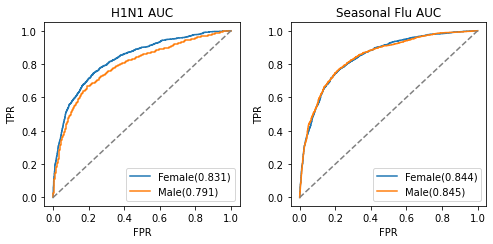

In [232]:
#Train/test for each gender 
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
genders = [female, male]
genders_labels = [female_labels, male_labels]
names = ["Female", "Male"]
legend_h1n1 = []
legend_seasonal = []
for gender in range(len(genders)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        genders[gender],
        genders_labels[gender],
        test_size=0.33,
        shuffle=True,
        stratify=genders_labels[gender],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    #preds = preds_outcome #For Lasso

#y_preds for Random forest and Log reg (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
   index = y_eval.index)
    y_preds_outcome = pd.DataFrame(
    {
        "h1n1_vaccine": preds_outcome[:, 0],
        "seasonal_vaccine": preds_outcome[:, 1],
    },
   index = y_eval.index)

#y_preds for Lasso (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[:, 0],
#         "seasonal_vaccine": preds[:,1],
#     },
#     index = y_eval.index)
    
    #Overall MSE and ROC    
    print(names[gender], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[gender],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[gender],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
    print(names[gender],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[gender],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[gender],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    #print(names[gender], roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    
    #print(names[gender], roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Lasso
#     print(names[gender], "R2 Score", full_pipeline.score(X_eval, y_eval))
#     print(names[gender], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
#     print(names[gender], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Log/RF
    fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
    ax[0].plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
    ax[1].plot(fpr, tpr)
    legend_h1n1.append(names[gender]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
    legend_seasonal.append(names[gender]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")


ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[0].set_title(
    "H1N1 AUC"
)
ax[0].legend(legend_h1n1)

ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[1].set_ylabel('TPR')
ax[1].set_xlabel('FPR')
ax[1].set_title(
    "Seasonal Flu AUC"
)
ax[1].legend(legend_seasonal)
fig.tight_layout()

In [233]:
#Data for each age:
#First two groups are empty
nine = features_df_original.loc[features_df_original['age_group'] == "6 Months - 9 Years"]
nine_labels = labels_df.iloc[[i for i in list(nine.index)]]
nine = features_df.iloc[[i for i in list(nine.index)]]
#nine = features_df[list(nine.index)] #For PCA
print(len(nine_labels))

seventeen = features_df_original.loc[features_df_original['age_group'] == "10 - 17 Years"]
seventeen_labels = labels_df.iloc[[i for i in list(seventeen.index)]]
seventeen = features_df.iloc[[i for i in list(seventeen.index)]]
#seventeen = features_df[list(seventeen.index)] #For PCA
print(len(seventeen_labels))

thirty_four = features_df_original.loc[features_df_original['age_group'] == "18 - 34 Years"]
thirty_four_labels = labels_df.iloc[[i for i in list(thirty_four.index)]]
thirty_four = features_df.iloc[[i for i in list(thirty_four.index)]]
#thirty_four = features_df[list(thirty_four.index)] #For PCA
print(len(thirty_four_labels))

forty_four = features_df_original.loc[features_df_original['age_group'] == "35 - 44 Years"]
forty_four_labels = labels_df.iloc[[i for i in list(forty_four.index)]]
forty_four = features_df.iloc[[i for i in list(forty_four.index)]] 
#forty_four = features_df[list(forty_four.index)] #For PCA
print(len(forty_four_labels))

fifty_four = features_df_original.loc[features_df_original['age_group'] == "45 - 54 Years"]
fifty_four_labels = labels_df.iloc[[i for i in list(fifty_four.index)]]
fifty_four = features_df.iloc[[i for i in list(fifty_four.index)]]
#fifty_four = features_df[list(fifty_four.index)] #For PCA
print(len(fifty_four_labels))

sixty_four = features_df_original.loc[features_df_original['age_group'] == "55 - 64 Years"]
sixty_four_labels = labels_df.iloc[[i for i in list(sixty_four.index)]]
sixty_four = features_df.iloc[[i for i in list(sixty_four.index)]]
#sixty_four = features_df[list(sixty_four.index)] #For PCA
print(len(sixty_four_labels))

sixty_five = features_df_original.loc[features_df_original['age_group'] == "65+ Years"]
sixty_five_labels = labels_df.iloc[[i for i in list(sixty_five.index)]]
sixty_five = features_df.iloc[[i for i in list(sixty_five.index)]]
#sixty_five = features_df[list(sixty_five.index)] #For PCA
print(len(sixty_five_labels))

0
0
5215
3848
5238
5563
6843


18 - 34 Years Accuracy 0.8326554328878559
18 - 34 Years Precision 0.6077348066298343
18 - 34 Years Recall 0.3363914373088685
18 - 34 Years Accuracy 0.7838466008134806
18 - 34 Years Precision 0.6629526462395543
18 - 34 Years Recall 0.4867075664621677
35 - 44 Years Accuracy 0.8251968503937008
35 - 44 Years Precision 0.5828571428571429
35 - 44 Years Recall 0.4063745019920319
35 - 44 Years Accuracy 0.7385826771653543
35 - 44 Years Precision 0.6675324675324675
35 - 44 Years Recall 0.5574837310195228
45 - 54 Years Accuracy 0.8519375361480624
45 - 54 Years Precision 0.6816143497757847
45 - 54 Years Recall 0.45103857566765576
45 - 54 Years Accuracy 0.7721226142278774
45 - 54 Years Precision 0.7373417721518988
45 - 54 Years Recall 0.6714697406340058
55 - 64 Years Accuracy 0.8044662309368191
55 - 64 Years Precision 0.6346749226006192
55 - 64 Years Recall 0.45964125560538116
55 - 64 Years Accuracy 0.7467320261437909
55 - 64 Years Precision 0.7505285412262156
55 - 64 Years Recall 0.756123535676251

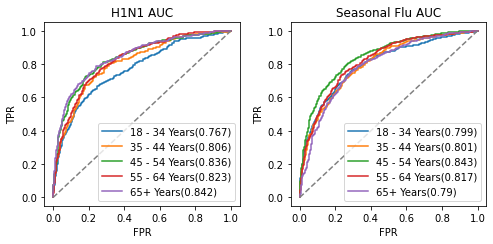

In [234]:
#Train/test for each age group 
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
ages = [thirty_four, forty_four, fifty_four, sixty_four, sixty_five]
ages_labels = [thirty_four_labels, forty_four_labels, fifty_four_labels, sixty_four_labels, sixty_five_labels]
legend_h1n1 = []
legend_seasonal = []
names = ["18 - 34 Years","35 - 44 Years", "45 - 54 Years", "55 - 64 Years", "65+ Years"]
for age in range(len(ages)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        ages[age],
        ages_labels[age],
        test_size=0.33,
        shuffle=True,
        stratify=ages_labels[age],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    #preds = preds_outcome #For Lasso

#y_preds for Random forest and Log reg (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
   index = y_eval.index)
    y_preds_outcome = pd.DataFrame(
    {
        "h1n1_vaccine": preds_outcome[:, 0],
        "seasonal_vaccine": preds_outcome[:, 1],
    },
   index = y_eval.index)

#y_preds for Lasso (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[:, 0],
#         "seasonal_vaccine": preds[:,1],
#     },
#     index = y_eval.index)
    
    #Overall MSE and ROC
    #For Log/RF
    print(names[age], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[age],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    print(names[age],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
    print(names[age],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[age],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    print(names[age],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
    
    #print(names[age], roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    
    #print(names[age], roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Lasso
#     print(names[age], "R2 Score", full_pipeline.score(X_eval, y_eval))
#     print(names[age], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
#     print(names[age], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Log/RF
    fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
    ax[0].plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
    ax[1].plot(fpr, tpr)
    legend_h1n1.append(names[age]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
    legend_seasonal.append(names[age]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")


ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[0].set_title(
    "H1N1 AUC"
)
ax[0].legend(legend_h1n1)
ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[1].set_ylabel('TPR')
ax[1].set_xlabel('FPR')
ax[1].set_title(
    "Seasonal Flu AUC"
)
ax[1].legend(legend_seasonal)
fig.tight_layout()

In [160]:
#Data for health insurance:
none = features_df_original.loc[features_df_original['health_insurance'] == 0]
none_labels = labels_df.iloc[[i for i in list(none.index)]]
none = features_df.iloc[[i for i in list(none.index)]]
print(len(none_labels))

has = features_df_original.loc[features_df_original['health_insurance'] == 1]
has_labels = labels_df.iloc[[i for i in list(has.index)]]
has = features_df.iloc[[i for i in list(has.index)]]
print(len(has_labels))

3545
18475


No Health Insurance R2 Score -5.097650435104129e-07
No Health Insurance 0.17504063481627585
No Health Insurance 0.24681085177880047
Health Insurance R2 Score -1.0598169009057301e-09
Health Insurance 0.16967774755894902
Health Insurance 0.2478694090860608


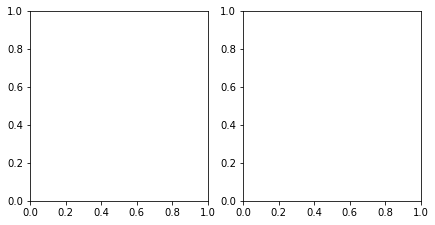

In [181]:
#Train/test for health insurance
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
hi = [none, has]
hi_labels = [none_labels, has_labels]
legend_h1n1 = []
legend_seasonal = []
names = ["No Health Insurance","Health Insurance"]
for p in range(len(hi)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        hi[p],
        hi_labels[p],
        test_size=0.33,
        shuffle=True,
        stratify=hi_labels[p],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    #preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    preds = preds_outcome #For Lasso

# #y_preds for Random forest and Log reg (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[0][:, 1],
#         "seasonal_vaccine": preds[1][:, 1],
#     },
#    index = y_eval.index)
#     y_preds_outcome = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds_outcome[:, 0],
#         "seasonal_vaccine": preds_outcome[:, 1],
#     },
#    index = y_eval.index)

#y_preds for Lasso (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[:, 0],
        "seasonal_vaccine": preds[:,1],
    },
    index = y_eval.index)
    #Overall MSE and ROC
    #For Log/RF
#     print(names[p], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
#     print(names[p],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))

    #print(names[p], roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    
    #print(names[p], roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Lasso
    print(names[p], "R2 Score", full_pipeline.score(X_eval, y_eval))
    print(names[p], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[p], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
#     fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
#     ax[0].plot(fpr, tpr)
#     fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
#     ax[1].plot(fpr, tpr)
#     legend_h1n1.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
#     legend_seasonal.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")


# ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[0].set_ylabel('TPR')
# ax[0].set_xlabel('FPR')
# ax[0].set_title(
#     "H1N1 AUC"
# )
# ax[0].legend(legend_h1n1)
# ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[1].set_ylabel('TPR')
# ax[1].set_xlabel('FPR')
# ax[1].set_title(
#     "Seasonal Flu AUC"
# )
# ax[1].legend(legend_seasonal)
# fig.tight_layout()

In [182]:
#Data for marital status:
not_married = features_df_original.loc[features_df_original['marital_status'] == "Not Married"]
not_married_labels = labels_df.iloc[[i for i in list(not_married.index)]]
not_married = features_df.iloc[[i for i in list(not_married.index)]]
print(len(not_married_labels))

married = features_df_original.loc[features_df_original['marital_status'] == "Married"]
married_labels = labels_df.iloc[[i for i in list(married.index)]]
married = features_df.iloc[[i for i in list(married.index)]]
print(len(married_labels))

18867
19307


Not Married R2 Score -6.73004711959635e-08
Not Married 0.17266633897582154
Not Married 0.24758659416282303
Married R2 Score -1.9747338320108554e-08
Married 0.16944556859259022
Married 0.24638306840107305


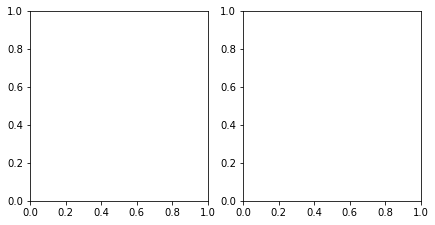

In [183]:
#Train/test for marital status
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
m = [not_married, married]
m_labels = [not_married_labels, married_labels]
legend_h1n1 = []
legend_seasonal = []
names = ["Not Married","Married"]
for p in range(len(m)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        m[p],
        m_labels[p],
        test_size=0.33,
        shuffle=True,
        stratify=m_labels[p],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    
    #preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    preds = preds_outcome #For Lasso

#y_preds for Random forest and Log reg (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[0][:, 1],
#         "seasonal_vaccine": preds[1][:, 1],
#     },
#    index = y_eval.index)
#     y_preds_outcome = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds_outcome[:, 0],
#         "seasonal_vaccine": preds_outcome[:, 1],
#     },
#    index = y_eval.index)

#y_preds for Lasso (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[:, 0],
        "seasonal_vaccine": preds[:,1],
    },
    index = y_eval.index)
    #Overall MSE and ROC
    #For Log/RF
    
#     print(names[p], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
#     print(names[p],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
        
    #For Lasso
    print(names[p], "R2 Score", full_pipeline.score(X_eval, y_eval))
    print(names[p], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[p], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))

    #For RF/Log
#     fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
#     ax[0].plot(fpr, tpr)
#     fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
#     ax[1].plot(fpr, tpr)
#     legend_h1n1.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
#     legend_seasonal.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")


# ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[0].set_ylabel('TPR')
# ax[0].set_xlabel('FPR')
# ax[0].set_title(
#     "H1N1 AUC"
# )
# ax[0].legend(legend_h1n1)
# ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[1].set_ylabel('TPR')
# ax[1].set_xlabel('FPR')
# ax[1].set_title(
#     "Seasonal Flu AUC"
# )
# ax[1].legend(legend_seasonal)
# fig.tight_layout()

In [146]:
#Data for income:
highest = features_df_original.loc[features_df_original['income_poverty'] == "> $75,000"]
highest_labels = labels_df.iloc[[i for i in list(highest.index)]]
highest = features_df.iloc[[i for i in list(highest.index)]]
print(len(highest_labels))

above = features_df_original.loc[features_df_original['income_poverty'] == "<= $75,000, Above Poverty"]
above_labels = labels_df.iloc[[i for i in list(above.index)]]
above = features_df.iloc[[i for i in list(above.index)]]
print(len(above_labels))

below = features_df_original.loc[features_df_original['income_poverty'] == "Below Poverty"]
below_labels = labels_df.iloc[[i for i in list(below.index)]]
below = features_df.iloc[[i for i in list(below.index)]]
print(len(below_labels))

12774
12813
12744


> $75,000 R2 Score -1.0500533342838736e-07
> $75,000 0.17053522696999213
> $75,000 0.2465189138089167
<= $75,000, Above Poverty R2 Score -4.680168319559641e-08
<= $75,000, Above Poverty 0.17333629442993145
<= $75,000, Above Poverty 0.24764532201759415
Below Poverty R2 Score -5.061844776665936e-08
Below Poverty 0.17011859054653752
Below Poverty 0.2470579863171264


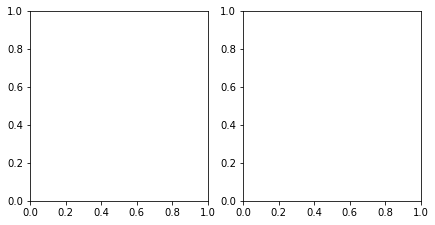

In [184]:
#Train/test for income
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
income = [highest, above, below]
income_labels = [highest_labels, above_labels, below_labels]
legend_h1n1 = []
legend_seasonal = []
names = ["> $75,000","<= $75,000, Above Poverty", "Below Poverty"]
for p in range(len(income)):
    X_train, X_eval, y_train, y_eval = train_test_split(
        income[p],
        income_labels[p],
        test_size=0.33,
        shuffle=True,
        stratify=income_labels[p],
        random_state=RANDOM_SEED
    )
    full_pipeline.fit(X_train, y_train)
    #preds = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict_proba') #For Log and Random Forest
    preds_outcome = cross_val_predict(full_pipeline, X_eval, y_eval, cv=5, method='predict')
    preds = preds_outcome #For Lasso

#y_preds for Random forest and Log reg (Uncomment)
#     y_preds = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds[0][:, 1],
#         "seasonal_vaccine": preds[1][:, 1],
#     },
#    index = y_eval.index)
#     y_preds_outcome = pd.DataFrame(
#     {
#         "h1n1_vaccine": preds_outcome[:, 0],
#         "seasonal_vaccine": preds_outcome[:, 1],
#     },
#    index = y_eval.index)

#y_preds for Lasso (Uncomment)
    y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[:, 0],
        "seasonal_vaccine": preds[:,1],
    },
    index = y_eval.index)
    #Overall MSE and ROC
    #For Log/RF
#     print(names[p], "Accuracy", accuracy_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['h1n1_vaccine'], y_preds_outcome['h1n1_vaccine']))
    
#     print(names[p],"Accuracy", accuracy_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Precision", precision_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))
#     print(names[p],"Recall", recall_score(y_eval['seasonal_vaccine'], y_preds_outcome['seasonal_vaccine']))

    #For Lasso
    print(names[p], "R2 Score", full_pipeline.score(X_eval, y_eval))
    print(names[p], mean_squared_error(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
    print(names[p], mean_squared_error(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))
    
    #For Log/RF
#     fpr, tpr, thresholds = roc_curve(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'])
#     ax[0].plot(fpr, tpr)
#     fpr, tpr, thresholds = roc_curve(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'])
#     ax[1].plot(fpr, tpr)
#     legend_h1n1.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']), 3)) + ")")
#     legend_seasonal.append(names[p]+ "(" + str(round(roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']), 3)) + ")")


# ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[0].set_ylabel('TPR')
# ax[0].set_xlabel('FPR')
# ax[0].set_title(
#     "H1N1 AUC"
# )
# ax[0].legend(legend_h1n1)
# ax[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
# ax[1].set_ylabel('TPR')
# ax[1].set_xlabel('FPR')
# ax[1].set_title(
#     "Seasonal Flu AUC"
# )
# ax[1].legend(legend_seasonal)
# fig.tight_layout()